# Notebook to develop HMM model to investigate optimal angle selection

## Defining the targets we will be using in our multiaspect classification model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from scipy.special import spherical_jn, spherical_yn

import ipywidgets as widgets
from IPython.display import display

## Below is the analytical DWBA solution for a prolate spheroid geometry

In [2]:
def dwba_prolate_spheroid(L, a, g, h, ka, phi):
    """
    DWBA solution for a fluid prolate spheroid.
    Lee, W.-J., Lavery, A. C., and Stanton, T. K. (2012). 
    “Orientation dependence of broadband acoustic backscattering from live squid,” 
    The Journal of the Acoustical Society of America, 131, 4461–4475. doi:10.1121/1.3701876
    
    Parameters
    ----------
    L : float
        Length of spheroid (long axis) [m]
    a : float
        Radius of spheroid (short axis) [m]
    g : float
        Density contrast (rho2/rho1)
    h : float
        Sound speed contrast (c2/c1)
    ka : array_like
        Dimensionless ka (wavenumber * radius)
    phi : float or array_like
        Incident angle [radians]

    Returns
    -------
    fbs : array_like
        Complex backscattering amplitude
    """
    # Convert inputs to arrays and ensure proper broadcasting
    ka = np.atleast_1d(ka)
    phi = np.atleast_1d(phi)

    # Calculate contrast term
    contrast = 1/(g * h**2) + 1/g - 2
    
    # Convert incident angle to beta
    beta = phi[..., np.newaxis] + np.pi / 2  # Add dimension for broadcasting with ka
    # beta = phi + np.pi/2
    
    # Calculate aspect ratio term (L/2a)
    aspect_ratio = L / (2 * a)

    # Calculate argument for Bessel function
    ellip_term = np.sqrt(np.sin(beta)**2 + (aspect_ratio**2) * np.cos(beta)**2)
    bessel_arg = 2 * ka / h * ellip_term
    
    # Calculate spherical Bessel function
    j1 = spherical_jn(1, bessel_arg)
    
    # Calculate final backscattering amplitude
    fbs = (ka**2) * L * contrast/2 * j1/bessel_arg

    return fbs.squeeze()

## Defining the measurement and target constants

In [3]:
a = 0.15 # semi-minor axis (equatorial radius)
g = 1.043 # density contrast
h = 1.053 # sound speed contrast
c = 1500 # speed of sound in water

freq_lowerbound = 100 # frequency response lower bound
freq_upperbound = 30e3 # frequency response upper bound
freq = np.arange(freq_lowerbound, freq_upperbound, 10)
k = 2*np.pi*freq / c # acoustic wavenumber (phase shift per meter)
ka = k*a

measurement_angle_step = 0.5
angle_all = np.arange(0, 360, measurement_angle_step)

## Below is code borrowed from the [BOAT fundamentals repository](https://boat-fundamentals.readthedocs.io/en/latest/acoustics/TS_03_discrete.html#orientation-dependency)

It has been modified to include an aspect ratio parameter so we can see the 2 targets we need using the slider: a sphere (AR = 1) and spheroid (AR > 1)

In [4]:
def plot_dwba_for_prolate_spheroid(angle, aspect_ratio):
    L = aspect_ratio*2*a

    # TS across all angles
    phi_all = np.deg2rad(angle_all)
    fbs_full = dwba_prolate_spheroid(L, a, g, h, ka, phi_all)
    TS_all = 20*np.log10(np.abs(fbs_full))

    phi = np.deg2rad(angle)
    fbs = dwba_prolate_spheroid(L, a, g, h, ka, phi)
    TS = 20*np.log10(np.abs(fbs))

    # Define ellipse parameters
    width = 2*a  # width
    height = L  # height
    ellipse_angle = 90-angle  # rotation angle [deg]

    # Create the ellipse patch
    ellipse = patches.Ellipse(
        (0.5, 0.5), width, height, angle=ellipse_angle, 
        facecolor='lightblue', edgecolor='blue')

    fig = plt.figure(figsize=(7,6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])
    fig.subplots_adjust(hspace=0.1)

    # All angles
    ax0 = fig.add_subplot(gs[0,0])
    ax0.imshow(TS_all, aspect="auto", vmax=-25, vmin=-80,
                extent=(0, freq_upperbound//1e3, 0, 360))
    ax0.set_yticks(np.arange(0, 361, 60))
    ax0.set_ylabel("Incident angle (°)", fontsize=12)
    ax0.set_xlim(freq_lowerbound, freq_upperbound)
    ax0.axhline(angle, color="magenta")

    # One angle slice
    ax1 = fig.add_subplot(gs[1,0], sharex=ax0)
    ax1.plot(freq/1e3, TS, lw=0.75)
    ax1.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
    ax1.set_ylim(-90, -20)
    ax1.set_xlabel("Frequency (kHz)", fontsize=12)
    ax1.set_ylabel("TS (dB)", fontsize=12)

    # Ellipse (cross section of prolate spheroid)
    ax_ellip = fig.add_subplot(gs[1,1])
    ax_ellip.add_patch(ellipse)
    ax_ellip.annotate("Incident sound", xytext=(0.5, 1.2), xy=(0.5, 0.95),
        arrowprops=dict(arrowstyle="->,head_length=0.5,head_width=0.3",
                        linewidth=2),
        fontsize=12,
        ha="center")
    ax_ellip.set_aspect('equal', adjustable='box')
    ax_ellip.axis('off')
    ax_ellip.set_xlim(0, 1)
    ax_ellip.set_ylim(0, 1.2)

    ax0.set_title("TS of a fluid prolate spheroid")
    plt.tight_layout()
    plt.show()

    return TS_all

## Below I have attached two visualizations but both are using the same function

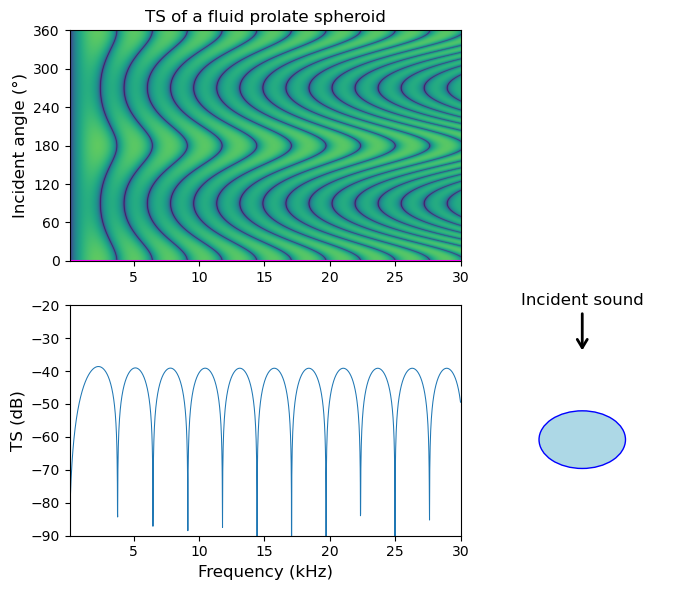

In [5]:
target1_AR = 1.5
TS_all_target1 = plot_dwba_for_prolate_spheroid(angle=0, aspect_ratio=target1_AR)

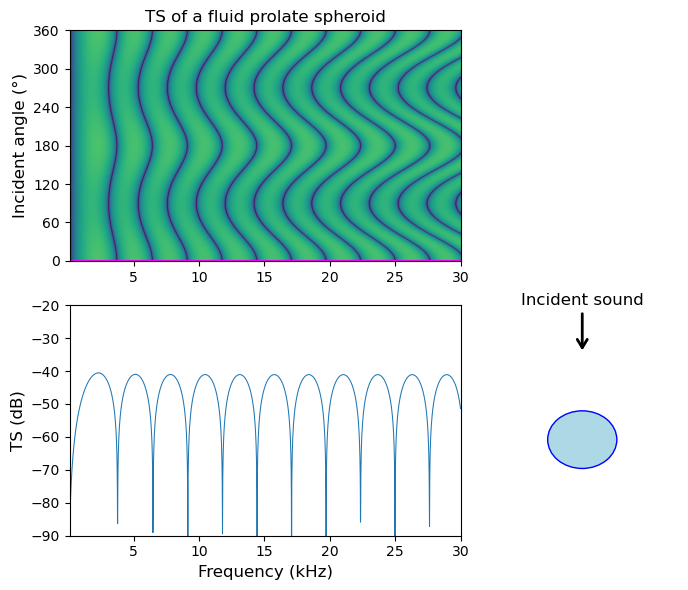

In [6]:
target2_AR = 1.2
TS_all_target2 = plot_dwba_for_prolate_spheroid(angle=0, aspect_ratio=target2_AR)

## Extract the acoustic color from the above functions and plot them side-by-side below

In [7]:
target_ARs = np.arange(1.5, 1.3, -0.1)
target_ARs

array([1.5, 1.4])

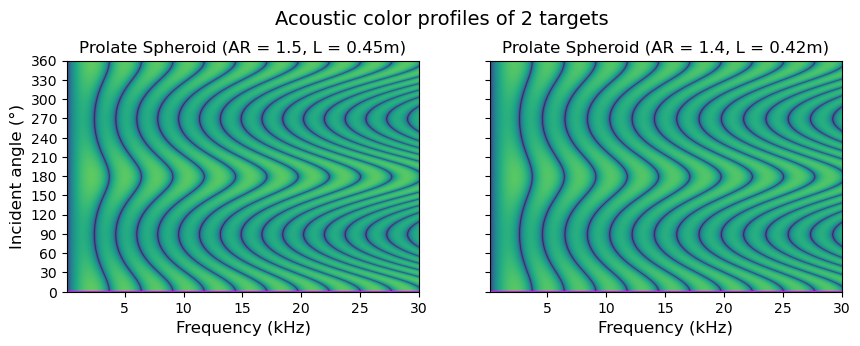

In [8]:
fig, ax = plt.subplots(1, target_ARs.shape[0], figsize=(5*target_ARs.shape[0],3), sharey=True)
plt.rcParams.update({'font.size':10})
fig.subplots_adjust(hspace=0.1)
fig.suptitle(f'Acoustic color profiles of {target_ARs.shape[0]} targets', y=1.05, fontsize=plt.rcParams['font.size']+4)

TS_all_targets = np.zeros((target_ARs.shape[0], angle_all.shape[0], freq.shape[0]))
for i, target_AR in enumerate(target_ARs):
    L = target_AR * 2*a
    phi_all = np.deg2rad(angle_all)
    fbs_full = dwba_prolate_spheroid(L, a, g, h, ka, phi_all)
    TS_all_targets[i,:,:] = 20*np.log10(np.abs(fbs_full))

    ax_TS = ax[i]
    ax_TS.set_title(f'Prolate Spheroid (AR = {target_AR:.1f}, L = {target_AR*2*a:.2f}m)')
    ax_TS.imshow(TS_all_targets[i,:] , aspect="auto", vmax=-25, vmin=-80,
                extent=(0, freq_upperbound//1e3, 0, 360))
    ax_TS.set_yticks(np.arange(0, 361, 30))
    if i==0:
        ax_TS.set_ylabel("Incident angle (°)", fontsize=12)
    ax_TS.axhline(0, color="magenta")
    ax_TS.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
    ax_TS.set_xlabel("Frequency (kHz)", fontsize=12)

plt.show()

In [9]:
all_waveforms_collection = np.vstack(TS_all_targets)
all_waveforms_collection

array([[-85.64708092, -83.99397243, -82.48527668, ..., -48.83383597,
        -49.13767041, -49.45380027],
       [-85.6470821 , -83.99397386, -82.48527838, ..., -48.87728219,
        -49.18283231, -49.5008053 ],
       [-85.64708564, -83.99397813, -82.48528347, ..., -49.0090163 ,
        -49.31981751, -49.64343629],
       ...,
       [-86.24635353, -84.59324675, -83.08455287, ..., -49.73818214,
        -50.05423444, -50.38350612],
       [-86.24634901, -84.59324128, -83.08454636, ..., -49.56730198,
        -49.87646179, -50.19831503],
       [-86.2463463 , -84.59323799, -83.08454245, ..., -49.46644643,
        -49.77159699, -50.08914066]], shape=(1440, 2990))

In [10]:
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd

/Users/adityakrishna/.local/share/mamba/envs/muri-info/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


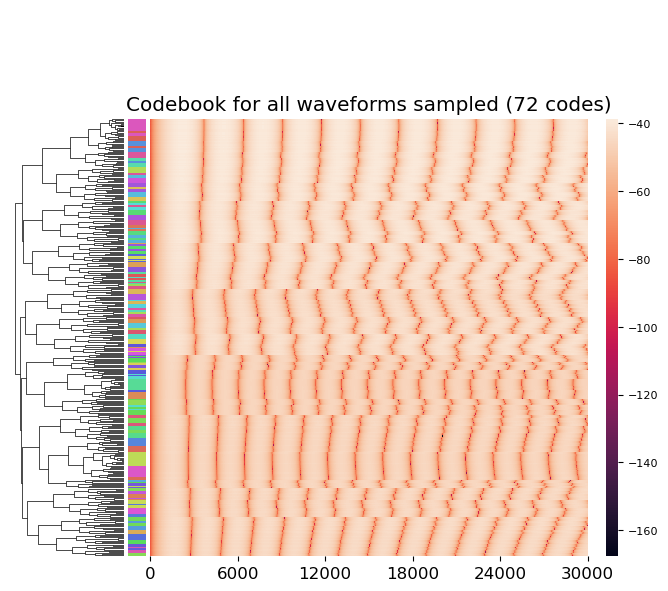

In [11]:
# Perform k-means clustering
k = all_waveforms_collection.shape[0]//20
state = 1500
kmean_TS_codebook = KMeans(n_clusters=k, n_init=10, random_state=state).fit(all_waveforms_collection)

# Create row colors for clustermap
labels = kmean_TS_codebook.labels_

# Get k distinct colors from a Seaborn palette
palette = sns.color_palette("hls", k)
# Map each cluster label to a color
row_colors = [palette[label] for label in labels]

plt.rcParams.update({'font.size':12})
# Create the clustermap
grid_cluster = sns.clustermap(
    all_waveforms_collection,
    col_cluster=False,
    row_colors=row_colors,
    cbar_pos=(1.0, 0.145, 0.02, 0.663),
    yticklabels=False,
    tree_kws=dict(linewidths=0.5, colors='k')
)

# Extract the figure and axes from sns.clustermap
fig = grid_cluster.figure
heatmap_ax = grid_cluster.ax_heatmap
dendro_ax = grid_cluster.ax_row_dendrogram

heatmap_ax.set_title(f'Codebook for all waveforms sampled ({k} codes)')
fig.set_figheight(6)
fig.set_figwidth(6)
# Adjust heatmap and dendrogram positions to align perfectly
heatmap_bbox = heatmap_ax.get_position(original=False)
dendro_bbox = dendro_ax.get_position(original=False)

# Reduce white space by directly setting the positions
heatmap_ax.set_position([heatmap_bbox.x0, heatmap_bbox.y0, heatmap_bbox.width, heatmap_bbox.height])
dendro_ax.set_position([dendro_bbox.x0, heatmap_bbox.y0, dendro_bbox.width, heatmap_bbox.height])

xticks = np.linspace(0, 3000, 6)
# Customize heatmap x-axis
heatmap_ax.set_xticks(xticks*(2985/3000))
heatmap_ax.set_xticklabels((xticks*10).astype(int), rotation=0)
heatmap_ax.set_ylabel('')
heatmap_ax.set_xlabel('')

# Adjust the colorbar position and labels
cbar = grid_cluster.cax
cbar.set_position([heatmap_bbox.x1 + 0.03, heatmap_bbox.y0, 0.02, heatmap_bbox.height]) 
cbar.tick_params(labelsize=plt.rcParams['font.size']-4)
plt.show()

In [12]:
state_angle_step = 5

In [13]:
kmean_TS_codebook.n_clusters

72

In [14]:
kmean_TS_codebook.labels_

array([62, 62, 62, ..., 62, 62, 62], shape=(1440,), dtype=int32)

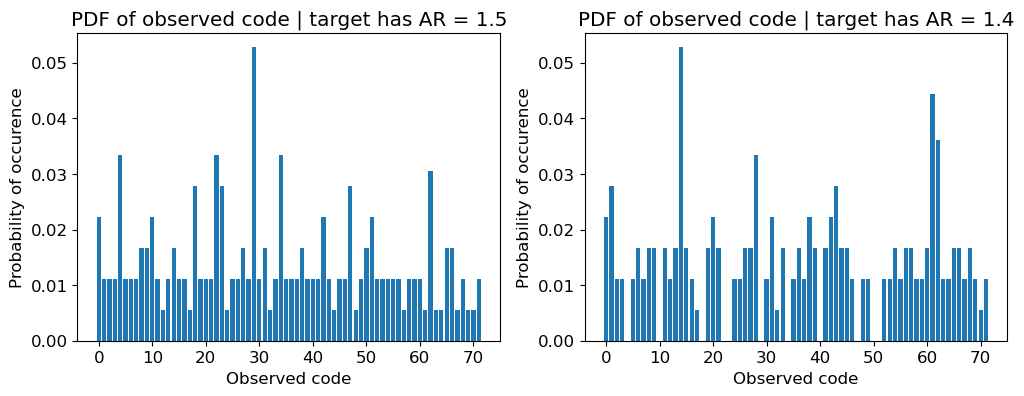

In [15]:
fig, ax = plt.subplots(1, TS_all_targets.shape[0], figsize=(6*TS_all_targets.shape[0], 4))

for i in range(TS_all_targets.shape[0]):
    target_cluster_preds = kmean_TS_codebook.predict(TS_all_targets[i,:])
    density, clusters = np.histogram(target_cluster_preds, bins=np.arange(0, kmean_TS_codebook.n_clusters+1), density=True)

    pdf_ax = ax[i]
    pdf_ax.set_title(f'PDF of observed code | target has AR = {target_ARs[i]:.1f}')
    pdf_ax.bar(x=clusters[:-1], height=density)
    pdf_ax.set_ylabel('Probability of occurence')
    pdf_ax.set_xlabel('Observed code')

plt.show()

In [16]:
state_centers = np.arange(0, 360, state_angle_step) + 2.5
state_centers

array([  2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
        47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5,
        92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5,
       137.5, 142.5, 147.5, 152.5, 157.5, 162.5, 167.5, 172.5, 177.5,
       182.5, 187.5, 192.5, 197.5, 202.5, 207.5, 212.5, 217.5, 222.5,
       227.5, 232.5, 237.5, 242.5, 247.5, 252.5, 257.5, 262.5, 267.5,
       272.5, 277.5, 282.5, 287.5, 292.5, 297.5, 302.5, 307.5, 312.5,
       317.5, 322.5, 327.5, 332.5, 337.5, 342.5, 347.5, 352.5, 357.5])

In [17]:
state_centers.shape

(72,)

In [18]:
state_center = state_centers[0]
state_center

np.float64(2.5)

In [19]:
angle_indices_for_state = np.where((state_center-(state_angle_step/2)<=angle_all)&(angle_all<state_center+(state_angle_step/2)))
angle_indices_for_state

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),)

In [20]:
angle_all[angle_indices_for_state]

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5])

In [21]:
TS_state_target1 = TS_all_targets[0, angle_indices_for_state, :][0]
TS_state_target1

array([[-85.64708092, -83.99397243, -82.48527668, ..., -48.83383597,
        -49.13767041, -49.45380027],
       [-85.6470821 , -83.99397386, -82.48527838, ..., -48.87728219,
        -49.18283231, -49.5008053 ],
       [-85.64708564, -83.99397813, -82.48528347, ..., -49.0090163 ,
        -49.31981751, -49.64343629],
       ...,
       [-85.64713858, -83.9940422 , -82.48535972, ..., -51.28524161,
        -51.69982702, -52.13650189],
       [-85.6471562 , -83.99406352, -82.48538509, ..., -52.20411446,
        -52.66873996, -53.16094575],
       [-85.64717615, -83.99408766, -82.48541383, ..., -53.38044615,
        -53.91743554, -54.49115328]], shape=(10, 2990))

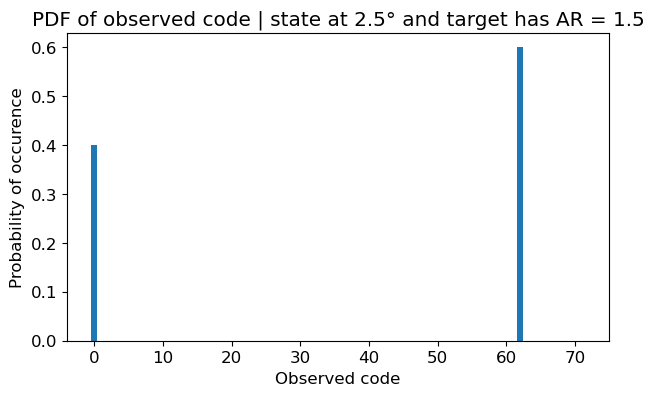

In [22]:
target1_state_cluster_preds = kmean_TS_codebook.predict(TS_state_target1)
density, clusters = np.histogram(target1_state_cluster_preds, bins=np.arange(0, kmean_TS_codebook.n_clusters+1), density=True)

fig, ax = plt.subplots(1, 1, figsize=(7,4))

ax.set_title(f'PDF of observed code | state at {state_center}° and target has AR = {target1_AR}')
ax.bar(x=clusters[:-1], height=density)
ax.set_ylabel('Probability of occurence')
ax.set_xlabel('Observed code')
plt.show()

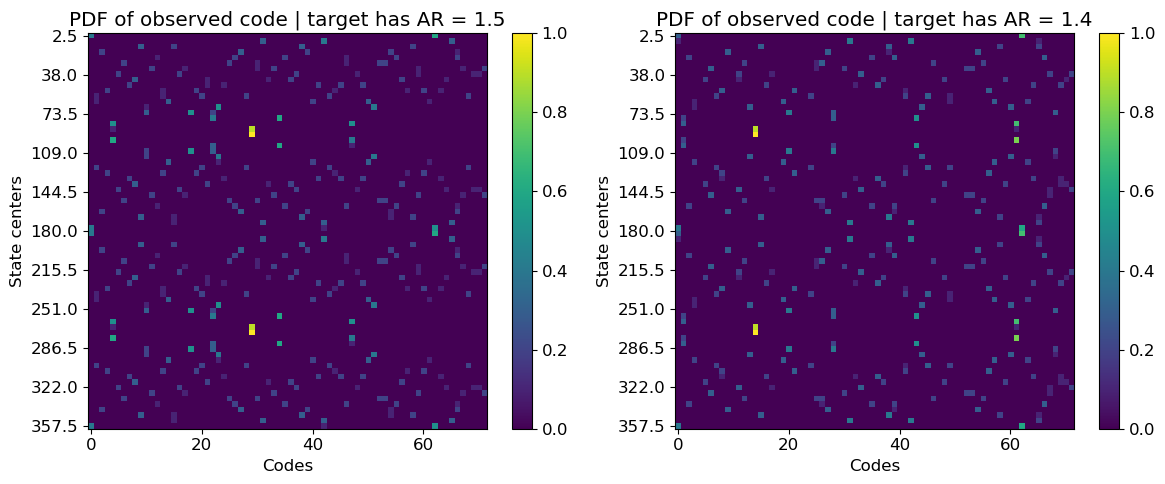

In [23]:
fig, ax_all = plt.subplots(1, TS_all_targets.shape[0], figsize=(6*TS_all_targets.shape[0], 5))

emission_matrix_B_targets = np.zeros((state_centers.shape[0], kmean_TS_codebook.n_clusters, TS_all_targets.shape[0]))
for k in range(TS_all_targets.shape[0]):
    for i, state_center in enumerate(state_centers):
        angle_indices_for_state = np.where((state_center-(state_angle_step/2)<=angle_all)&(angle_all<state_center+(state_angle_step/2)))
        TS_state_target_k = TS_all_targets[k, angle_indices_for_state][0]
        target_k_state_cluster_preds = kmean_TS_codebook.predict(TS_state_target_k)

        density, clusters = np.histogram(target_k_state_cluster_preds, bins=np.arange(0, kmean_TS_codebook.n_clusters+1), density=True)
        emission_matrix_B_targets[i, :, k] = density

    ax = ax_all[k]
    im = ax.imshow(emission_matrix_B_targets[:,:,k], aspect='auto')
    fig.colorbar(im, ax=ax)
    ax.set_title(f'PDF of observed code | target has AR = {target_ARs[k]}')

    ax.set_yticks(np.linspace(0, state_centers.shape[0]-1, 11))
    ax.set_yticklabels(np.linspace(0, 355, 11)+2.5)
    ax.set_ylabel('State centers')
    ax.set_xlabel('Codes')

plt.tight_layout()
plt.show()

In [24]:
state_centers

array([  2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
        47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5,
        92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5,
       137.5, 142.5, 147.5, 152.5, 157.5, 162.5, 167.5, 172.5, 177.5,
       182.5, 187.5, 192.5, 197.5, 202.5, 207.5, 212.5, 217.5, 222.5,
       227.5, 232.5, 237.5, 242.5, 247.5, 252.5, 257.5, 262.5, 267.5,
       272.5, 277.5, 282.5, 287.5, 292.5, 297.5, 302.5, 307.5, 312.5,
       317.5, 322.5, 327.5, 332.5, 337.5, 342.5, 347.5, 352.5, 357.5])

In [45]:
(state_centers[np.newaxis, :] - state_centers[:, np.newaxis])

array([[   0.,    5.,   10., ...,  345.,  350.,  355.],
       [  -5.,    0.,    5., ...,  340.,  345.,  350.],
       [ -10.,   -5.,    0., ...,  335.,  340.,  345.],
       ...,
       [-345., -340., -335., ...,    0.,    5.,   10.],
       [-350., -345., -340., ...,   -5.,    0.,    5.],
       [-355., -350., -345., ...,  -10.,   -5.,    0.]], shape=(72, 72))

In [46]:
prior_class_prob = 1/2
true_target_L = target_ARs[1]*2*a
posteriors = np.zeros((3600, target_ARs.shape[0]))

initial_state_prob = state_angle_step / 360
for i_state, initial_state in enumerate(np.arange(0, 360, 0.1)):
    # initial_state = 1 # np.random.uniform(low=0, high=360)

    alpha_targets = initial_state_prob * emission_matrix_B_targets

    phi = np.deg2rad(initial_state)
    fbs = dwba_prolate_spheroid(true_target_L, a, g, h, ka, phi)

    received_TS = 20*np.log10(np.abs(fbs))
    received_code = kmean_TS_codebook.predict(received_TS.reshape((1, freq.shape[0])))[0]
    alpha_targets_for_received_code = alpha_targets[:,received_code,:]
    likelihood_targets_for_received_code = alpha_targets_for_received_code.sum(axis=0)
    posterior = (likelihood_targets_for_received_code) / np.sum(likelihood_targets_for_received_code)
    posteriors[i_state,:] = posterior

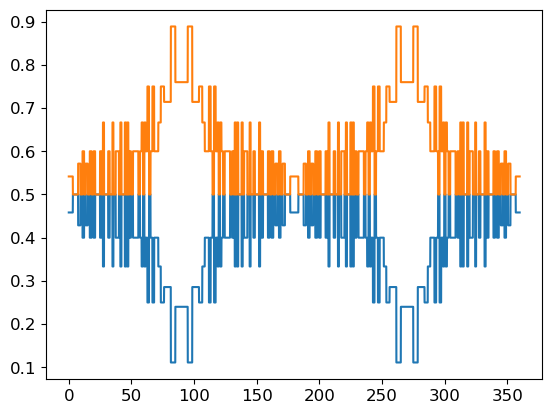

In [47]:
plt.plot(np.arange(0, 360, 0.1), posteriors)

In [80]:
prior_class_prob = 1/2
true_target_L = target_ARs[1]*2*a
posteriors = np.zeros((3600, target_ARs.shape[0]))

initial_state_prob = state_angle_step / 360
initial_state = 139.06426777 # np.random.uniform(low=0, high=360)

alpha_targets = initial_state_prob * emission_matrix_B_targets

phi = np.deg2rad(initial_state)
fbs = dwba_prolate_spheroid(true_target_L, a, g, h, ka, phi)

received_TS = 20*np.log10(np.abs(fbs))
received_code = kmean_TS_codebook.predict(received_TS.reshape((1, freq.shape[0])))[0]
alpha_targets_for_received_code = alpha_targets[:,received_code,:]
likelihood_targets_for_received_code = alpha_targets_for_received_code.sum(axis=0)
posterior = (likelihood_targets_for_received_code) / np.sum(likelihood_targets_for_received_code)
posterior

array([0.5, 0.5])

In [81]:
emission_matrix_B_targets[:,received_code,:]

array([[0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0.1, 0. ],
       [0.1, 0. ],
       [0. , 0.2],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0.2],
       [0. , 0. ],
       [0.2, 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0.1, 0. ],
       [0.1, 0. ],
       [0. , 0.2],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. , 0. ],
       [0. ,

In [82]:
alpha_targets_for_received_code.shape

(72, 2)

In [83]:
entropy_of_current_belief = -1 * np.sum(posterior * np.log10(posterior + np.nextafter(0, 1)))
entropy_of_current_belief

np.float64(0.3010299956639812)

In [84]:
candidate_angle_steps = np.array([-5, 5])
candidate_angle_steps

array([-5,  5])

In [85]:
candidate_next_states = candidate_angle_steps + initial_state
candidate_next_states

array([134.06426777, 144.06426777])

In [86]:
candidate_angle_step = candidate_angle_steps[0]
candidate_next_state = candidate_next_states[0]
candidate_next_state, candidate_angle_step

(np.float64(134.06426777), np.int64(-5))

In [87]:
def w_(theta):
    sigma_i = state_angle_step / 2
    normalization = 1 / np.sqrt(2*np.pi*(sigma_i**2))

    return normalization * np.exp(-0.5*((theta/sigma_i)**2))

def state_transition_model(delta_angle):
    angular_dist_between_states = (state_centers[np.newaxis, :] - state_centers[:, np.newaxis])

    return w_(angular_dist_between_states - delta_angle)

In [88]:
A_step = state_transition_model(candidate_angle_step)
A_step

array([[2.15963866e-02, 5.35320903e-05, 2.43035314e-09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.59576912e-01, 2.15963866e-02, 5.35320903e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.15963866e-02, 1.59576912e-01, 2.15963866e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.15963866e-02, 5.35320903e-05, 2.43035314e-09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.59576912e-01, 2.15963866e-02, 5.35320903e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.15963866e-02, 1.59576912e-01, 2.15963866e-02]], shape=(72, 72))

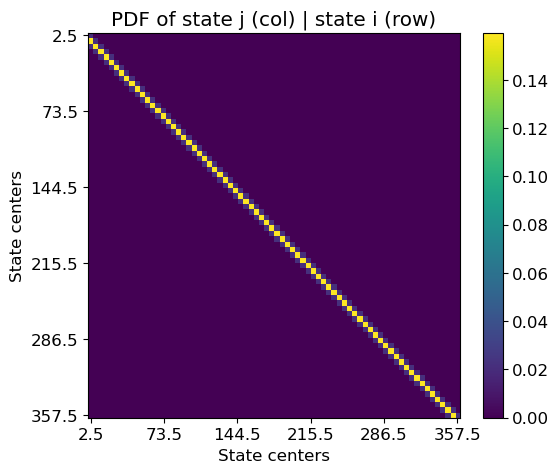

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

im = ax.imshow(A_step, aspect='auto')
fig.colorbar(im, ax=ax)
ax.set_title(f'PDF of state j (col) | state i (row)')

ax.set_yticks(np.linspace(0, state_centers.shape[0]-1, 6))
ax.set_yticklabels(np.linspace(0, 355, 6)+2.5)

ax.set_xticks(np.linspace(0, state_centers.shape[0]-1, 6))
ax.set_xticklabels(np.linspace(0, 355, 6)+2.5)
ax.set_ylabel('State centers')
ax.set_xlabel('State centers')
plt.show()

In [90]:
test_a = np.array([[1, 2, 3],
                   [4, 5, 6]]).T
test_M = np.array([[3, 4, 5],
                   [5, 6, 1],
                   [8, 5, 2]])
test_a, test_M

(array([[1, 4],
        [2, 5],
        [3, 6]]),
 array([[3, 4, 5],
        [5, 6, 1],
        [8, 5, 2]]))

In [91]:
np.matmul(test_a.T, test_M) == np.array([[np.sum(test_a[:,0] * test_M[:,0]), np.sum(test_a[:,0] * test_M[:,1]), np.sum(test_a[:,0] * test_M[:,2])],
                                       [np.sum(test_a[:,1] * test_M[:,0]), np.sum(test_a[:,1] * test_M[:,1]), np.sum(test_a[:,1] * test_M[:,2])]])

array([[ True,  True,  True],
       [ True,  True,  True]])

In [92]:
likelihood_observing_and_transitioning = np.matmul(alpha_targets_for_received_code.T, A_step).T
likelihood_observing_and_transitioning

array([[4.27477702e-026, 1.21845173e-046],
       [2.80681731e-018, 2.38487082e-035],
       [3.37549328e-012, 8.54955403e-026],
       [7.43535009e-008, 5.61363454e-018],
       [3.00693315e-005, 6.75098094e-012],
       [2.51629582e-004, 1.48700251e-007],
       [2.51629582e-004, 5.99899628e-005],
       [3.00693315e-005, 4.43269200e-004],
       [7.43535009e-008, 5.99899628e-005],
       [3.37549328e-012, 1.48700251e-007],
       [2.80681731e-018, 6.75098094e-012],
       [4.27477702e-026, 5.61363454e-018],
       [1.19243541e-035, 8.54955403e-026],
       [6.09225866e-047, 2.38487082e-035],
       [5.70090596e-060, 1.21845173e-046],
       [9.77083079e-075, 1.14018119e-059],
       [3.06719353e-091, 1.95416616e-074],
       [5.29046925e-109, 1.95416616e-074],
       [6.13438707e-091, 1.14018119e-059],
       [1.95416616e-074, 1.21845173e-046],
       [1.14018119e-059, 2.38487082e-035],
       [1.21845173e-046, 8.54955403e-026],
       [2.38487082e-035, 5.61363454e-018],
       [8.5

In [93]:
alpha_targets_for_forecasted_codes = likelihood_observing_and_transitioning[:, np.newaxis, :] * emission_matrix_B_targets
alpha_targets_for_forecasted_codes

array([[[1.70991081e-26, 3.65535520e-47],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 2.38487082e-36],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00]],

       ...,

       [[0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00],
     

In [94]:
likelihood_targets_for_forecasted_codes = alpha_targets_for_forecasted_codes.sum(axis=0)
(likelihood_targets_for_forecasted_codes, likelihood_targets_for_forecasted_codes.shape)

(array([[3.41982161e-26, 4.76974163e-36],
        [2.24545382e-18, 1.43092249e-35],
        [2.97414004e-08, 2.70039238e-12],
        [2.70039350e-12, 2.70039238e-12],
        [2.34499939e-74, 0.00000000e+00],
        [1.89335413e-04, 4.79919702e-05],
        [1.00711313e-04, 3.59939817e-05],
        [5.94814505e-08, 5.94801003e-08],
        [3.60385898e-05, 1.12649829e-04],
        [2.02529597e-12, 3.36818072e-18],
        [9.53948327e-36, 0.00000000e+00],
        [1.24647818e-04, 1.89394893e-04],
        [6.01386765e-06, 5.94801003e-08],
        [2.70039294e-12, 3.36818072e-18],
        [5.12973242e-26, 2.28036238e-59],
        [1.35019731e-12, 5.12973242e-26],
        [1.89335413e-04, 1.77367160e-04],
        [6.23239089e-05, 8.86835801e-05],
        [1.21845173e-46, 0.00000000e+00],
        [2.70039350e-12, 4.05058857e-12],
        [2.24545383e-18, 6.83964322e-26],
        [2.40108565e-05, 3.59939817e-05],
        [7.31071040e-47, 0.00000000e+00],
        [1.70991081e-26, 0.0000000

In [95]:
numerator = likelihood_targets_for_forecasted_codes.sum(axis=1)
denominator = likelihood_targets_for_received_code.sum()
numerator / denominator

array([1.53891973e-24, 1.01045422e-16, 1.33848453e-06, 2.43035365e-10,
       1.05524973e-72, 1.06797322e-02, 6.15173825e-03, 5.35326979e-06,
       6.69097886e-03, 9.11384701e-11, 4.29276747e-34, 1.41319220e-02,
       2.73300649e-04, 1.21517834e-10, 2.30837959e-24, 6.07588790e-11,
       1.65016158e-02, 6.79533701e-03, 5.48303280e-45, 3.03794193e-10,
       1.01045426e-16, 2.70021772e-03, 3.28981968e-45, 7.69459864e-25,
       4.01493715e-06, 5.07325704e-03, 5.45262996e-04, 2.00754453e-06,
       1.01045426e-16, 5.52094836e-89, 5.61182853e-03, 7.57840674e-17,
       4.53133995e-03, 1.75814351e-02, 6.15697844e-58, 5.41248210e-04,
       1.30534410e-02, 1.06797322e-02, 9.11383691e-11, 1.33854529e-06,
       1.53891973e-24, 1.08383436e-03, 1.01045423e-16, 1.01045422e-16,
       6.07590053e-11, 6.69157205e-06, 2.53796694e-03, 1.02616307e-58,
       6.41968545e-03, 5.35326979e-06, 2.30837959e-24, 8.58553494e-34,
       5.61182853e-03, 5.61182853e-03, 1.33836302e-06, 5.43924693e-04,
      

In [96]:
forecasted_posteriors_for_codes = (likelihood_targets_for_forecasted_codes / np.sum(likelihood_targets_for_forecasted_codes))
(forecasted_posteriors_for_codes, forecasted_posteriors_for_codes.shape)

(array([[7.58549066e-24, 1.05797421e-33],
        [4.98063084e-16, 3.17392262e-33],
        [6.59692640e-06, 5.98972797e-10],
        [5.98973046e-10, 5.98972797e-10],
        [5.20143241e-72, 0.00000000e+00],
        [4.19964012e-02, 1.06450769e-02],
        [2.23387302e-02, 7.98380861e-03],
        [1.31935533e-05, 1.31932538e-05],
        [7.99370310e-03, 2.49868070e-02],
        [4.49229971e-10, 7.47094624e-16],
        [2.11594842e-33, 0.00000000e+00],
        [2.76480754e-02, 4.20095945e-02],
        [1.33393323e-03, 1.31932538e-05],
        [5.98972921e-10, 7.47094624e-16],
        [1.13782360e-23, 5.05806136e-57],
        [2.99486647e-10, 1.13782360e-23],
        [4.19964012e-02, 3.93417286e-02],
        [1.38240377e-02, 1.96708643e-02],
        [2.70264221e-44, 0.00000000e+00],
        [5.98973046e-10, 8.98459195e-10],
        [4.98063086e-16, 1.51709813e-23],
        [5.32583708e-03, 7.98380861e-03],
        [1.62158533e-44, 0.00000000e+00],
        [3.79274533e-24, 0.0000000

In [97]:
entropy_of_forecasted_belief_for_codes = -1 * (forecasted_posteriors_for_codes * np.log(forecasted_posteriors_for_codes + np.nextafter(0, 1))).sum(axis=1)
entropy_of_forecasted_belief_for_codes

array([4.03819701e-22, 1.75496537e-14, 7.87068393e-05, 2.54393440e-08,
       8.53748513e-70, 1.81492729e-01, 1.23483701e-01, 2.96476718e-04,
       1.30788910e-01, 9.66902109e-09, 1.59195082e-31, 2.32371218e-01,
       8.97837243e-03, 1.27196980e-08, 6.01116074e-22, 6.56742810e-09,
       2.60424752e-01, 1.36464779e-01, 2.71127753e-42, 3.14348849e-08,
       1.75496545e-14, 6.64462522e-02, 1.63504999e-42, 2.04538781e-22,
       2.26929309e-04, 1.00730238e-01, 1.60253782e-02, 1.14028944e-04,
       1.75496545e-14, 5.48692118e-86, 1.12786969e-01, 1.32697033e-14,
       9.30740799e-02, 2.66212700e-01, 3.94945144e-55, 1.58110598e-02,
       1.94901611e-01, 1.81492729e-01, 9.66900402e-09, 7.87128348e-05,
       4.03819701e-22, 2.80439523e-02, 1.75496539e-14, 1.75496537e-14,
       6.56745152e-09, 3.62571025e-04, 5.49124154e-02, 6.67304735e-56,
       1.29479679e-01, 2.96476718e-04, 6.01116074e-22, 3.15456837e-31,
       1.12786969e-01, 1.12786969e-01, 7.86941196e-05, 1.59592839e-02,
      

In [98]:
expected_entropy_of_forecasted_belief = (entropy_of_forecasted_belief_for_codes * numerator / denominator).sum()
expected_entropy_of_forecasted_belief

np.float64(0.03574657267554651)

In [99]:
delta_S = entropy_of_current_belief - expected_entropy_of_forecasted_belief
delta_S

np.float64(0.26528342298843466)

In [100]:
candidate_angle_step = candidate_angle_steps[1]
candidate_next_state = candidate_next_states[1]
candidate_next_state, candidate_angle_step

(np.float64(144.06426777), np.int64(5))

In [101]:
A_step = state_transition_model(candidate_angle_step)
A_step

array([[2.15963866e-02, 1.59576912e-01, 2.15963866e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.35320903e-05, 2.15963866e-02, 1.59576912e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.43035314e-09, 5.35320903e-05, 2.15963866e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.15963866e-02, 1.59576912e-01, 2.15963866e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.35320903e-05, 2.15963866e-02, 1.59576912e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.43035314e-09, 5.35320903e-05, 2.15963866e-02]], shape=(72, 72))

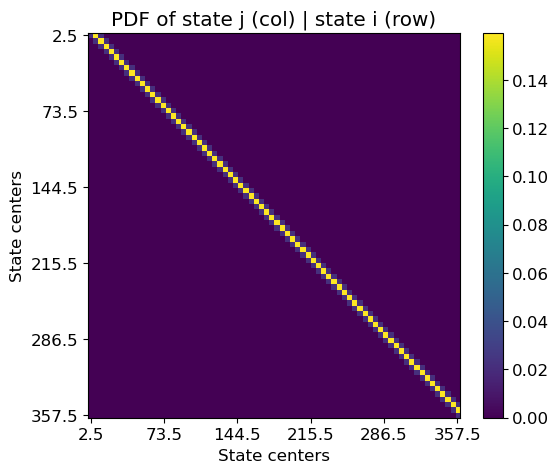

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

im = ax.imshow(A_step, aspect='auto')
fig.colorbar(im, ax=ax)
ax.set_title(f'PDF of state j (col) | state i (row)')

ax.set_yticks(np.linspace(0, state_centers.shape[0]-1, 6))
ax.set_yticklabels(np.linspace(0, 355, 6)+2.5)

ax.set_xticks(np.linspace(0, state_centers.shape[0]-1, 6))
ax.set_xticklabels(np.linspace(0, 355, 6)+2.5)
ax.set_ylabel('State centers')
ax.set_xlabel('State centers')
plt.show()

In [103]:
likelihood_observing_and_transitioning = np.matmul(alpha_targets_for_received_code.T, A_step).T
likelihood_observing_and_transitioning

array([[6.09225866e-047, 1.95416616e-074],
       [1.19243541e-035, 1.14018119e-059],
       [4.27477702e-026, 1.21845173e-046],
       [2.80681731e-018, 2.38487082e-035],
       [3.37549328e-012, 8.54955403e-026],
       [7.43535009e-008, 5.61363454e-018],
       [3.00693315e-005, 6.75098094e-012],
       [2.51629582e-004, 1.48700251e-007],
       [2.51629582e-004, 5.99899628e-005],
       [3.00693315e-005, 4.43269200e-004],
       [7.43535009e-008, 5.99899628e-005],
       [3.37549328e-012, 1.48700251e-007],
       [2.80681731e-018, 6.75098094e-012],
       [4.27477702e-026, 5.61363454e-018],
       [1.19243541e-035, 8.54955403e-026],
       [6.09225866e-047, 2.38487082e-035],
       [5.70090596e-060, 1.21845173e-046],
       [9.77083079e-075, 1.14018119e-059],
       [3.06719353e-091, 1.95416616e-074],
       [5.29046925e-109, 1.95416616e-074],
       [6.13438707e-091, 1.14018119e-059],
       [1.95416616e-074, 1.21845173e-046],
       [1.14018119e-059, 2.38487082e-035],
       [1.2

In [104]:
alpha_targets_for_forecasted_codes = likelihood_observing_and_transitioning[:, np.newaxis, :] * emission_matrix_B_targets
alpha_targets_for_forecasted_codes

array([[[2.43690347e-47, 5.86249848e-75],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 1.14018119e-60],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00]],

       ...,

       [[0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00],
     

In [105]:
likelihood_targets_for_forecasted_codes = alpha_targets_for_forecasted_codes.sum(axis=0)
(likelihood_targets_for_forecasted_codes, likelihood_targets_for_forecasted_codes.shape)

(array([[6.83964322e-26, 9.74761386e-47],
        [6.75099217e-13, 9.53948327e-36],
        [5.94801003e-08, 2.70039238e-12],
        [2.97414004e-08, 1.35019731e-12],
        [5.70090596e-60, 0.00000000e+00],
        [1.00711313e-04, 4.79919702e-05],
        [1.77337422e-04, 3.59939817e-05],
        [1.20277326e-05, 5.94801003e-08],
        [1.50977753e-04, 3.60237204e-05],
        [4.05058857e-12, 3.36818072e-18],
        [8.54955404e-27, 0.00000000e+00],
        [3.60237177e-05, 2.78018993e-04],
        [1.19979932e-05, 5.94801003e-08],
        [1.48713753e-08, 3.36818072e-18],
        [1.68409039e-18, 2.05232615e-59],
        [1.35019731e-12, 5.12973242e-26],
        [1.00711313e-04, 1.77367160e-04],
        [1.80118589e-05, 8.86835801e-05],
        [1.19243541e-35, 0.00000000e+00],
        [2.97414004e-08, 4.05058857e-12],
        [1.35019731e-12, 6.83964322e-26],
        [5.63397853e-05, 3.59939817e-05],
        [4.76974163e-36, 0.00000000e+00],
        [4.27477702e-26, 0.0000000

In [106]:
numerator = likelihood_targets_for_forecasted_codes.sum(axis=1)
denominator = likelihood_targets_for_received_code.sum()
numerator / denominator

array([3.07783945e-24, 3.03794648e-11, 2.67672603e-06, 1.33842378e-06,
       2.56540768e-58, 6.69164773e-03, 9.59991315e-03, 5.43924572e-04,
       8.41506631e-03, 1.82276637e-10, 3.84729932e-25, 1.41319220e-02,
       5.42586300e-04, 6.69211888e-07, 7.57840674e-17, 6.07588790e-11,
       1.25135313e-02, 4.80129476e-03, 5.36595934e-34, 1.33854529e-06,
       6.07588790e-11, 4.15501952e-03, 2.14638374e-34, 1.92364966e-24,
       2.73300588e-04, 7.98286064e-03, 1.08249606e-03, 4.01490677e-06,
       6.07588790e-11, 7.91437294e-73, 9.32995823e-03, 1.51568133e-16,
       6.25542740e-03, 1.35933506e-02, 3.28981968e-45, 1.07981951e-03,
       1.65016159e-02, 6.69164773e-03, 1.82276485e-10, 2.67672603e-06,
       5.05227116e-17, 1.08383436e-03, 1.51568133e-16, 6.07588790e-11,
       6.69181508e-07, 5.45262874e-04, 1.08316515e-03, 2.56540768e-58,
       4.42564320e-03, 5.42586330e-04, 7.57840674e-17, 1.53891973e-24,
       9.06000342e-03, 9.06000342e-03, 1.33836302e-06, 1.08249600e-03,
      

In [107]:
forecasted_posteriors_for_codes = (likelihood_targets_for_forecasted_codes / np.sum(likelihood_targets_for_forecasted_codes))
(forecasted_posteriors_for_codes, forecasted_posteriors_for_codes.shape)

(array([[1.51709813e-23, 2.16211377e-44],
        [1.49743448e-10, 2.11594842e-33],
        [1.31932538e-05, 5.98972797e-10],
        [6.59692640e-06, 2.99486647e-10],
        [1.26451534e-57, 0.00000000e+00],
        [2.23387302e-02, 1.06450769e-02],
        [3.93351323e-02, 7.98380861e-03],
        [2.66786586e-03, 1.31932538e-05],
        [3.34883063e-02, 7.99040493e-03],
        [8.98459195e-10, 7.47094624e-16],
        [1.89637267e-24, 0.00000000e+00],
        [7.99040433e-03, 6.16672655e-02],
        [2.66126939e-03, 1.31932538e-05],
        [3.29861294e-06, 7.47094624e-16],
        [3.73547318e-16, 4.55225523e-57],
        [2.99486647e-10, 1.13782360e-23],
        [2.23387302e-02, 3.93417286e-02],
        [3.99520217e-03, 1.96708643e-02],
        [2.64493552e-33, 0.00000000e+00],
        [6.59692640e-06, 8.98459195e-10],
        [2.99486647e-10, 1.51709813e-23],
        [1.24967020e-02, 7.98380861e-03],
        [1.05797421e-33, 0.00000000e+00],
        [9.48186333e-24, 0.0000000

In [108]:
entropy_of_forecasted_belief_for_codes = -1 * (forecasted_posteriors_for_codes * np.log(forecasted_posteriors_for_codes + np.nextafter(0, 1))).sum(axis=1)
entropy_of_forecasted_belief_for_codes

array([7.97123679e-22, 3.38751091e-09, 1.48249546e-04, 7.87006870e-05,
       1.65667520e-55, 1.33276135e-01, 1.65838725e-01, 1.59592810e-02,
       1.52334778e-01, 1.87152364e-08, 1.03583856e-22, 2.10394896e-01,
       1.59267754e-02, 4.16351206e-05, 1.32697033e-14, 6.56742810e-09,
       2.12208157e-01, 9.93434337e-02, 1.98403653e-31, 7.87128348e-05,
       6.56742810e-09, 9.33286863e-02, 8.03308730e-32, 5.02658810e-22,
       8.97837075e-03, 1.27422457e-01, 2.80160143e-02, 2.14331133e-04,
       6.56742810e-09, 6.41433654e-70, 1.58094552e-01, 2.60215596e-14,
       1.27457843e-01, 2.05595668e-01, 1.63504999e-42, 2.78677872e-02,
       2.51888130e-01, 1.33276135e-01, 1.87152104e-08, 1.48249546e-04,
       8.94744245e-15, 3.16545812e-02, 2.60215598e-14, 6.56742810e-09,
       4.16333803e-05, 1.60253753e-02, 2.80299813e-02, 1.65667520e-55,
       9.85585519e-02, 1.58897383e-02, 1.32697033e-14, 4.03819701e-22,
       1.55141993e-01, 1.55141993e-01, 7.86941196e-05, 2.80160113e-02,
      

In [109]:
expected_entropy_of_forecasted_belief = (entropy_of_forecasted_belief_for_codes * numerator / denominator).sum()
expected_entropy_of_forecasted_belief

np.float64(0.032515189017045976)

In [110]:
delta_S = entropy_of_current_belief - expected_entropy_of_forecasted_belief
delta_S

np.float64(0.2685148066469352)

In [111]:
prior_class_prob = 1/2
true_target_L = target_ARs[1]*2*a
posteriors = np.zeros((3600, target_ARs.shape[0]))
candidate_angle_steps = np.arange(-1, 2, 2)

initial_state_prob = state_angle_step / 360
optim_angle_steps = np.zeros(3600)

for i_state, initial_state in enumerate(np.arange(0, 360, 0.1)):
    # initial_state = 153 # np.random.uniform(low=0, high=360)

    alpha_targets = initial_state_prob * emission_matrix_B_targets

    phi = np.deg2rad(initial_state)
    fbs = dwba_prolate_spheroid(true_target_L, a, g, h, ka, phi)

    received_TS = 20*np.log10(np.abs(fbs))
    received_code = kmean_TS_codebook.predict(received_TS.reshape((1, freq.shape[0])))[0]
    alpha_targets_for_received_code = alpha_targets[:,received_code,:]
    likelihood_targets_for_received_code = alpha_targets_for_received_code.sum(axis=0)
    posterior = (likelihood_targets_for_received_code) / np.sum(likelihood_targets_for_received_code)
    posteriors[i_state,:] = posterior

    entropy_of_current_belief = -1 * np.sum(posterior * np.log10(posterior + np.nextafter(0, 1)))
    candidate_next_states = candidate_angle_steps + initial_state
    forecasted_delta_S_vals_per_trial = np.zeros(candidate_angle_steps.shape[0])

    for a_step, candidate_angle_step in enumerate(candidate_angle_steps):
        A_step = state_transition_model(candidate_angle_step)
        likelihood_observing_and_transitioning = np.matmul(alpha_targets_for_received_code.T, A_step).T

        alpha_targets_for_forecasted_codes = likelihood_observing_and_transitioning[:, np.newaxis, :] * emission_matrix_B_targets
        likelihood_targets_for_forecasted_codes = alpha_targets_for_forecasted_codes.sum(axis=0)

        numerator = likelihood_targets_for_forecasted_codes.sum(axis=1)
        denominator = likelihood_targets_for_received_code.sum()

        forecasted_posteriors_for_codes = (likelihood_targets_for_forecasted_codes / np.sum(likelihood_targets_for_forecasted_codes))
        entropy_of_forecasted_belief_for_codes = -1 * (forecasted_posteriors_for_codes * np.log(forecasted_posteriors_for_codes + np.nextafter(0, 1))).sum(axis=1)
        expected_entropy_of_forecasted_belief = (entropy_of_forecasted_belief_for_codes * numerator / denominator).sum()

        delta_S = entropy_of_current_belief - expected_entropy_of_forecasted_belief
        forecasted_delta_S_vals_per_trial[a_step] = delta_S

    angle_step_to_make = candidate_angle_steps[(forecasted_delta_S_vals_per_trial).argmax()]
    optim_angle_steps[i_state] = angle_step_to_make

optim_angle_steps

array([-1., -1., -1., ..., -1., -1., -1.], shape=(3600,))

In [256]:
optim_angle_steps.sum()

np.float64(-3600.0)